In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors


## Import data

In [164]:
df = pd.read_csv('model_data.csv')
df.query("season == 2021",inplace=True)
df.head(5)

,game_id,season,date,arena,H_team,H_team_id,A_team,A_team_id,H_score,A_score,...,A_mean_tpp,A_mean_offReb,A_mean_defReb,A_mean_totReb,A_mean_assists,A_mean_pFouls,A_mean_steals,A_mean_turnovers,A_mean_blocks,A_mean_plusMinus
267,9542,2021,2021-08-16T00:00:00.000Z,NaN,Houston Rockets,14,Orlando Magic,26,76,89,...,35.99,8.3,36.8,45.1,23.2,22.2,7.7,14.3,4.0,-6.5
268,9543,2021,2021-08-16T01:00:00.000Z,NaN,New Orleans Pelicans,23,Golden State Warriors,11,80,79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,9544,2021,2021-08-16T02:00:00.000Z,NaN,Chicago Bulls,6,Memphis Grizzlies,19,91,96,...,34.37,10.8,39.0,49.8,27.7,21.1,9.6,14.8,4.9,4.5
270,9545,2021,2021-08-16T19:00:00.000Z,NaN,Washington Wizards,41,Indiana Pacers,15,65,74,...,36.73,7.8,32.3,40.1,24.6,24.1,10.2,15.8,4.6,-6.6
271,9546,2021,2021-08-16T20:00:00.000Z,NaN,Denver Nuggets,9,Milwaukee Bucks,21,94,87,...,31.03,10.2,37.4,47.6,22.9,21.1,7.6,14.6,4.7,-4.1


In [178]:
# 30 teams in the NBA (after removing ALLSTAR teams)
special_teams_names = ['Team Team Durant','Team LeBron','USA USA','World World']
dataset = df.loc[~df['H_team'].isin(special_teams_names) & ~df['A_team'].isin(special_teams_names)]

teams=dataset[['H_team_id','H_team']].drop_duplicates().sort_values('H_team',ignore_index=True).rename({'H_team_id':'team_id'},axis=1)
teams

,team_id,H_team
0,1,Atlanta Hawks
1,2,Boston Celtics
2,4,Brooklyn Nets
3,5,Charlotte Hornets
4,6,Chicago Bulls
5,7,Cleveland Cavaliers
6,8,Dallas Mavericks
7,9,Denver Nuggets
8,10,Detroit Pistons
9,11,Golden State Warriors


In [62]:
# drop = ['game_id', 'date', 'arena', 'H_team', 'H_team_id', 'A_team',
#        'A_team_id', 'H_score', 'A_score', 'ref1', 'ref2', 'ref3', 'ties',
#        'leadChange', 'nugget','H_game_id','A_game_id']

# Droping non-relevant fields
drop = ['game_id', 'date', 'arena', 'H_team_id', 'A_team_id',
       'H_score', 'A_score', 'ref1', 'ref2', 'ref3', 'ties',
       'leadChange', 'nugget','H_game_id','A_game_id']

dataset.drop(drop, axis=1, inplace=True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 267 to 1610
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   season                     1343 non-null   int64  
 1   H_team                     1343 non-null   object 
 2   A_team                     1343 non-null   object 
 3   H_Team_Elo_Before          1343 non-null   float64
 4   A_Team_Elo_Before          1343 non-null   float64
 5   result                     1343 non-null   int64  
 6   H_w_per_before             1343 non-null   float64
 7   H_w_per_last10games        1318 non-null   float64
 8   H_w_per_last5games         1340 non-null   float64
 9   H_game_number              1343 non-null   int64  
 10  H_mean_fastBreakPoints     1318 non-null   float64
 11  H_mean_pointsInPaint       1318 non-null   float64
 12  H_mean_biggestLead         1318 non-null   float64
 13  H_mean_secondChancePoints  1318 non-null   flo

/Users/eladh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Missing values

the missing data is only the starting games in each season where we didn't calculate the moving average

In [63]:
dataset.isnull().sum()

season                0
H_team                0
A_team                0
H_Team_Elo_Before     0
A_Team_Elo_Before     0
                     ..
A_mean_pFouls        20
A_mean_steals        20
A_mean_turnovers     20
A_mean_blocks        20
A_mean_plusMinus     20
Length: 64, dtype: int64

# Correlation Heatmap
ELO rating, biggest-lead, plus-minus and %-win are the most positive correlated features to result. 
Fouls & Turnovers are the most negative correlated features to result

In [90]:
home_cols = [col for col in dataset if col.startswith('H_')]
home_cols.append('result')

corr = dataset[home_cols].corr()
corr['res_rank'] = abs(corr['result']).rank(ascending=False)
corr['res_rank'].sort_values()

result                        1.0
H_Team_Elo_Before             2.0
H_mean_biggestLead            3.0
H_mean_plusMinus              4.0
H_w_per_before                5.0
H_w_per_last10games           6.0
H_w_per_last5games            7.0
H_mean_defReb                 8.0
H_mean_fgp                    9.0
H_mean_tpm                   10.0
H_mean_assists               11.0
H_mean_points                12.0
H_mean_totReb                13.0
H_mean_fgm                   14.0
H_mean_tpp                   15.0
H_mean_tpa                   16.0
H_mean_pFouls                17.0
H_mean_steals                18.0
H_mean_longestRun            19.0
H_mean_turnovers             20.0
H_mean_blocks                21.0
H_mean_pointsInPaint         22.0
H_mean_pointsOffTurnovers    23.0
H_mean_fastBreakPoints       24.0
H_mean_ftp                   25.0
H_game_number                26.0
H_mean_secondChancePoints    27.0
H_mean_fga                   28.0
H_mean_fta                   29.0
H_mean_offReb 

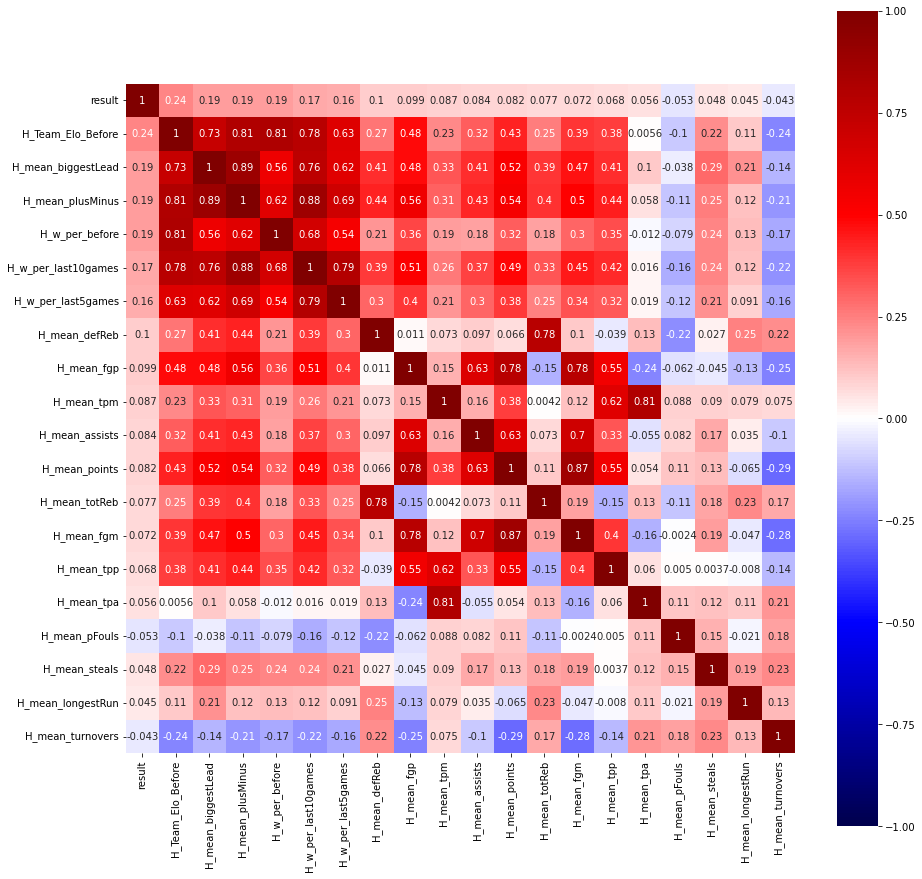

In [93]:
top_correlated = ['result',
                  'H_Team_Elo_Before',
                  'H_mean_biggestLead',
                  'H_mean_plusMinus',
                  'H_w_per_before',
                  'H_w_per_last10games',
                  'H_w_per_last5games',
                  'H_mean_defReb',
                  'H_mean_fgp',
                  'H_mean_tpm',
                  'H_mean_assists',
                  'H_mean_points',
                  'H_mean_totReb',
                  'H_mean_fgm',
                  'H_mean_tpp',
                  'H_mean_tpa',
                  'H_mean_pFouls',
                  'H_mean_steals',
                  'H_mean_longestRun',
                  'H_mean_turnovers']
corr = dataset[top_correlated].corr()

f, ax = plt.subplots(1, 1, figsize = (15, 15))
sns.heatmap(corr, annot=True, square=True, ax=ax, cmap='seismic', vmin=-1, vmax=1)
plt.show()

## Number of winnigs according to home and away team 

Home    0.548027
Away    0.451973
Name: result, dtype: float64

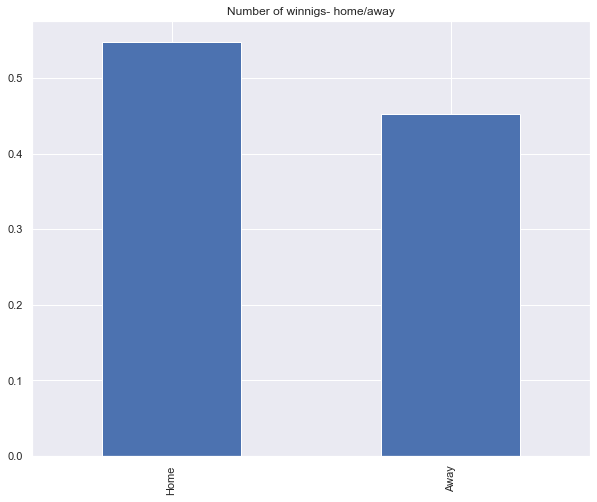

In [123]:
# Home-1, Away-0
# 55% of the games won by the home team

result = dataset['result'].replace({1:'Home',0:'Away'}).value_counts(normalize=True)
result.plot(kind='bar', figsize=(10,8))
plt.title('Number of winnigs- home/away')

result

<function matplotlib.pyplot.show(close=None, block=None)>

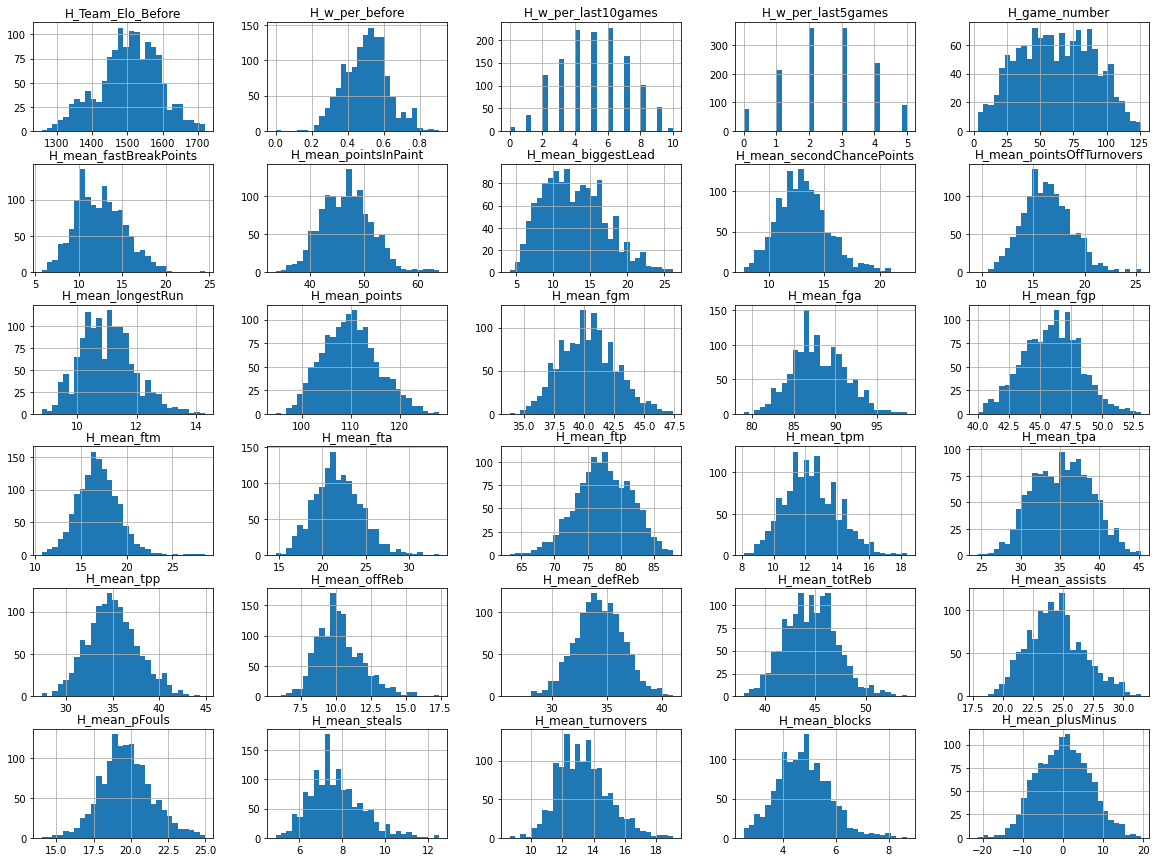

In [117]:
import matplotlib.pyplot as plt
dataset[home_cols].drop('result', axis=1).hist(bins = 30, figsize = (20,15))
plt.show